# Objective

The objective of this notebook is to explore the PK model presented in Betts et. al. 2019 paper.

In [1]:
using DifferentialEquations, Plots

# Two compartment PK

$
\begin{align}
\dot{C_c} &  = - k_{el} C_c - k_{pc} C_c + k_{cp} C_p \frac{V_c}{V_p} - k_d (C_c-\frac{C_t}{k_\varepsilon}) \frac{y(t)}{V_c},\\
\dot{C_p} &  = k_{pc} C_c \frac{V_p}{V_c} - k_{cp} C_p,\\
\dot{C_t} &  = k_d (C_c-\frac{C_t}{k_\varepsilon}) \frac{y(t)}{V_c}.
\end{align}
$

Where $k_d=\left( \frac{2 P R_{cap}}{R_{krogh}^2} + \frac{6 D}{R^2_{tumor}} \right) $ stands for tumor disposition coeffeicient.

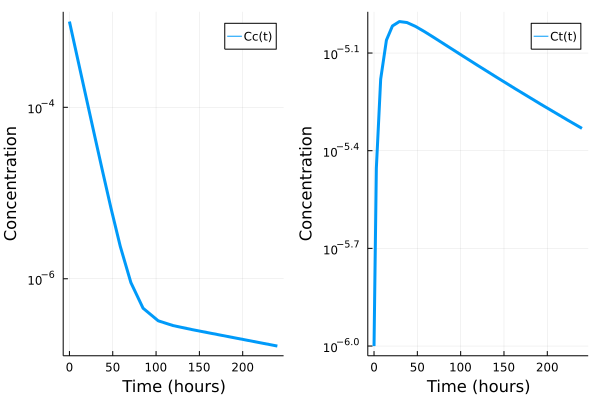

In [2]:
function PK(du,u,p,t)
    Cc, Cp, Ct = u
    kel, kcp, kpc, Vc, Vp, Vt, kd, kep = p 
    du[1]= -kel*Cc -kpc*Cc +kcp*Cp*Vc/Vp - kd*(Cc-Ct/kep)*Vt/Vc
    du[2]= kpc*Cc*Vp/Vc -kcp*Cp
    du[3]= kd*(Cc-Ct/kep)*Vt/Vc
end

P, Rcap, Rrogh, D, Rtumor =[334, 8, 75, 0.022, 0.62]
kd = 2*P*Rcap/Rrogh^2 + 6*D/Rtumor^2
x0 = [1e-3,0.0,0.0]
ts = (0.0,10.0)
p  = [2.51, 0.002, 0.0005, 49.6, 60.7, 1, kd, 0.24]
pkproblem  = ODEProblem(PK,x0,ts,p)
pksolution = solve(pkproblem, abstol=1e-9, reltol=1e-9)

p1 = plot(pksolution.t*24, pksolution[1,:], label="Cc(t)", yaxis=:log,
         ylabel="Concentration", xlabel="Time (hours)", linewidth=3)
p2 = plot(pksolution.t*24, pksolution[3,:].+1e-6, label="Ct(t)", yaxis=:log,
         ylabel="Concentration", xlabel="Time (hours)", linewidth=3)
p  = plot(p1,p2, layout=(1,2))

# PK and TME

Assuming no drug-target interaction outside tumor micro environment and minimal change in tumor size with the first dose.



$
\begin{align}
\dot{C_c} &  = - k_{el} C_c - k_{pc} C_c + k_{cp} C_p \frac{V_c}{V_p} - k_d (C_c-\frac{C_t}{k_\varepsilon}) \frac{y(t)}{V_c},\\
\dot{C_p} &  = k_{pc} C_c \frac{V_p}{V_c} - k_{cp} C_p,\\
\dot{C_t} &  = k_d (C_c-\frac{C_t}{k_\varepsilon}) \frac{y(t)}{V_c} - k_{n1} T1_t C_t - k_{n2} T2_t C_t + k_{f1} D1_t + k_{f2} D2_t,\\
\dot{T1_t} & = - k_{n1} T1_t C_t + k_{f1} D1_t - k_{n1} T1_t D2_t + k_{f1} R_t,\\
\dot{T2_t} & = - k_{n2} T2_t C_t + k_{f2} D2_t - k_{n2} T2_t D1_t + k_{f2} R_t,\\
\dot{D1_t} & = k_{n1} T1_t C_t - k_{f1} D1_t - k_{n2} T2_t D1_t + k_{f2} R_t ,\\
\dot{D2_t} & = k_{n2} T2_t C_t + k_{f2} D2_t - k_{n1} T1_t D2_t + k_{f1} R_t,\\
\dot{R_t} & = k_{n1} T1_t D2_t + k_{n2} T2_t D1_t - (k_{f1}+k_{f2}) R_t .
\end{align}
$

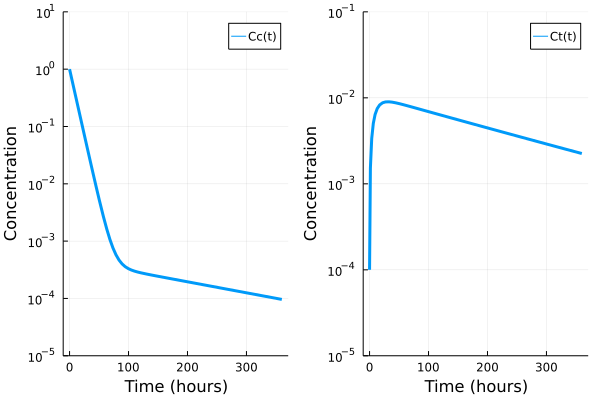

In [3]:
function PKTME(du,u,p,t)
    Cc, Cp, Cₜ, T1ₜ, T2ₜ, D1ₜ, D2ₜ, Rₜ = u
    kel, kcp, kpc, Vc, Vp, Vt, kd, kep, kn₁, kf₁, kn₂, kf₂ = p 
    du[1]= -kel*Cc -kpc*Cc +kcp*Cp*Vc/Vp - kd*(Cc-Cₜ/kep)*Vt/Vc
    du[2]= kpc*Cc*Vp/Vc -kcp*Cp
    du[3]= kd*(Cc-Cₜ/kep)*Vt/Vc -kn₁*T1ₜ*Cₜ -kn₂*T2ₜ*Cₜ +kf₁*D1ₜ +kf₂*D2ₜ
    du[4]= -kn₁*T1ₜ*Cₜ +kf₁*D1ₜ -kn₁*T1ₜ*D2ₜ +kf₁*Rₜ
    du[5]= -kn₂*T2ₜ*Cₜ +kf₂*D2ₜ -kn₂*T2ₜ*D1ₜ +kf₂*Rₜ
    du[6]= +kn₁*T1ₜ*Cₜ -kf₁*D1ₜ -kn₂*T2ₜ*D1ₜ +kf₂*Rₜ
    du[7]= +kn₂*T2ₜ*Cₜ -kf₂*D2ₜ -kn₁*T1ₜ*D2ₜ +kf₁*Rₜ
    du[8]= +kn₁*T1ₜ*D2ₜ +kn₂*T2ₜ*D1ₜ -(kf₁+kf₂)*Rₜ
end

P, Rcap, Rrogh, D, Rtumor =[334, 8, 75, 0.022, 0.62]
kd = 2*P*Rcap/Rrogh^2 + 6*D/Rtumor^2
x0 = [1,0.0,0.0,1.087e-4,4.766e-3,0.0,0.0,0.0]
ts = (0.0,15.0)
p  = [2.51, 0.002, 0.0005, 49.6, 60.7, 1, kd, 0.24, 1.72,19.66,1.57,0.74]
PKTMEproblem  = ODEProblem(PKTME,x0,ts,p)
PKTMEsolution = solve(PKTMEproblem, abstol=1e-9, reltol=1e-9)

p1 = plot(PKTMEsolution.t*24, PKTMEsolution[1,:], label="Cc(t)", yaxis=:log,
         ylabel="Concentration", xlabel="Time (hours)", linewidth=3, ylims=(1e-5,1e1))
p2 = plot(PKTMEsolution.t*24, PKTMEsolution[3,:].+1e-4, label="Ct(t)", yaxis=:log,
         ylabel="Concentration", xlabel="Time (hours)", linewidth=3, ylims=(1e-5,1e-1))
p  = plot(p1,p2, layout=(1,2))

# Adjourn

In [4]:
using Dates
println("mahdiar")
Dates.format(now(), "Y/U/d HH:MM")

mahdiar


"2022/January/24 11:39"